In [381]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime as dt
import arch

from financial_utils import plot_individual_stock, get_predicted_prices

plt.rcParams['figure.facecolor'] = 'white'

dashed_line_color = '#6E8AFF'
simulations_color = '#D5E0FF'
gt_color = 'black'
mean_color = '#FF2D43'
quartile_color = '#FFC7B2'

%matplotlib inline

In [382]:
# methods for the plots 

def legend_unique_labels():
    # Get existing handles and labels
    handles, labels = plt.gca().get_legend_handles_labels()

    # Filter out duplicate legend items
    unique_handles = []
    unique_labels = []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_handles.append(handle)
            unique_labels.append(label)

    # Create legend with unique items
    plt.legend(unique_handles, unique_labels)

def year_ticks():
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


def get_quartiles(prices):
    quartile_5 = np.percentile(prices[1:], 5, axis=1)
    quartile_95 = np.percentile(prices[1:], 95, axis=1)
    return quartile_5, quartile_95

In [383]:
# Define the list of companies and their corresponding names
company_list = ["AAPL", "GOOGL", "MSFT", "AMZN"]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

# Initialize an empty DataFrame to store the close prices
close_prices_df = pd.DataFrame()

# Loop through each company
for ticker, name in zip(company_list, company_name):
    # Construct the file path
    file_path = os.path.join("../data", "financial", f"{ticker}.csv")
    
    # Read the CSV file and keep only the "close" price
    df = pd.read_csv(file_path, parse_dates=["date"])
    df = df.set_index("date")
    df.rename(columns={"close": name}, inplace=True)
    df.drop(columns=["ticker", "open", "high", "low"], inplace=True)
    
    # Merge with the existing DataFrame
    if close_prices_df.empty:
        close_prices_df = df
    else:
        close_prices_df = close_prices_df.merge(df, how="outer", left_index=True, right_index=True)

# Sort the DataFrame by date
close_prices_df.sort_index(inplace=True)

# Drop rows with NaN values
close_prices_df.dropna(inplace=True)

# Display the resulting DataFrame
print(close_prices_df)


             APPLE  GOOGLE  MICROSOFT  AMAZON
date                                         
2004-08-19    0.55    2.51      27.12    1.93
2004-08-20    0.55    2.71      27.20    1.98
2004-08-23    0.56    2.74      27.24    1.97
2004-08-24    0.57    2.62      27.24    1.95
2004-08-25    0.59    2.65      27.55    2.02
...            ...     ...        ...     ...
2024-03-06  169.12  131.40     402.09  173.51
2024-03-07  169.00  134.38     409.14  176.82
2024-03-08  170.73  135.41     406.22  175.35
2024-03-11  172.75  137.67     404.52  171.96
2024-03-12  173.23  138.50     415.28  175.39

[4924 rows x 4 columns]


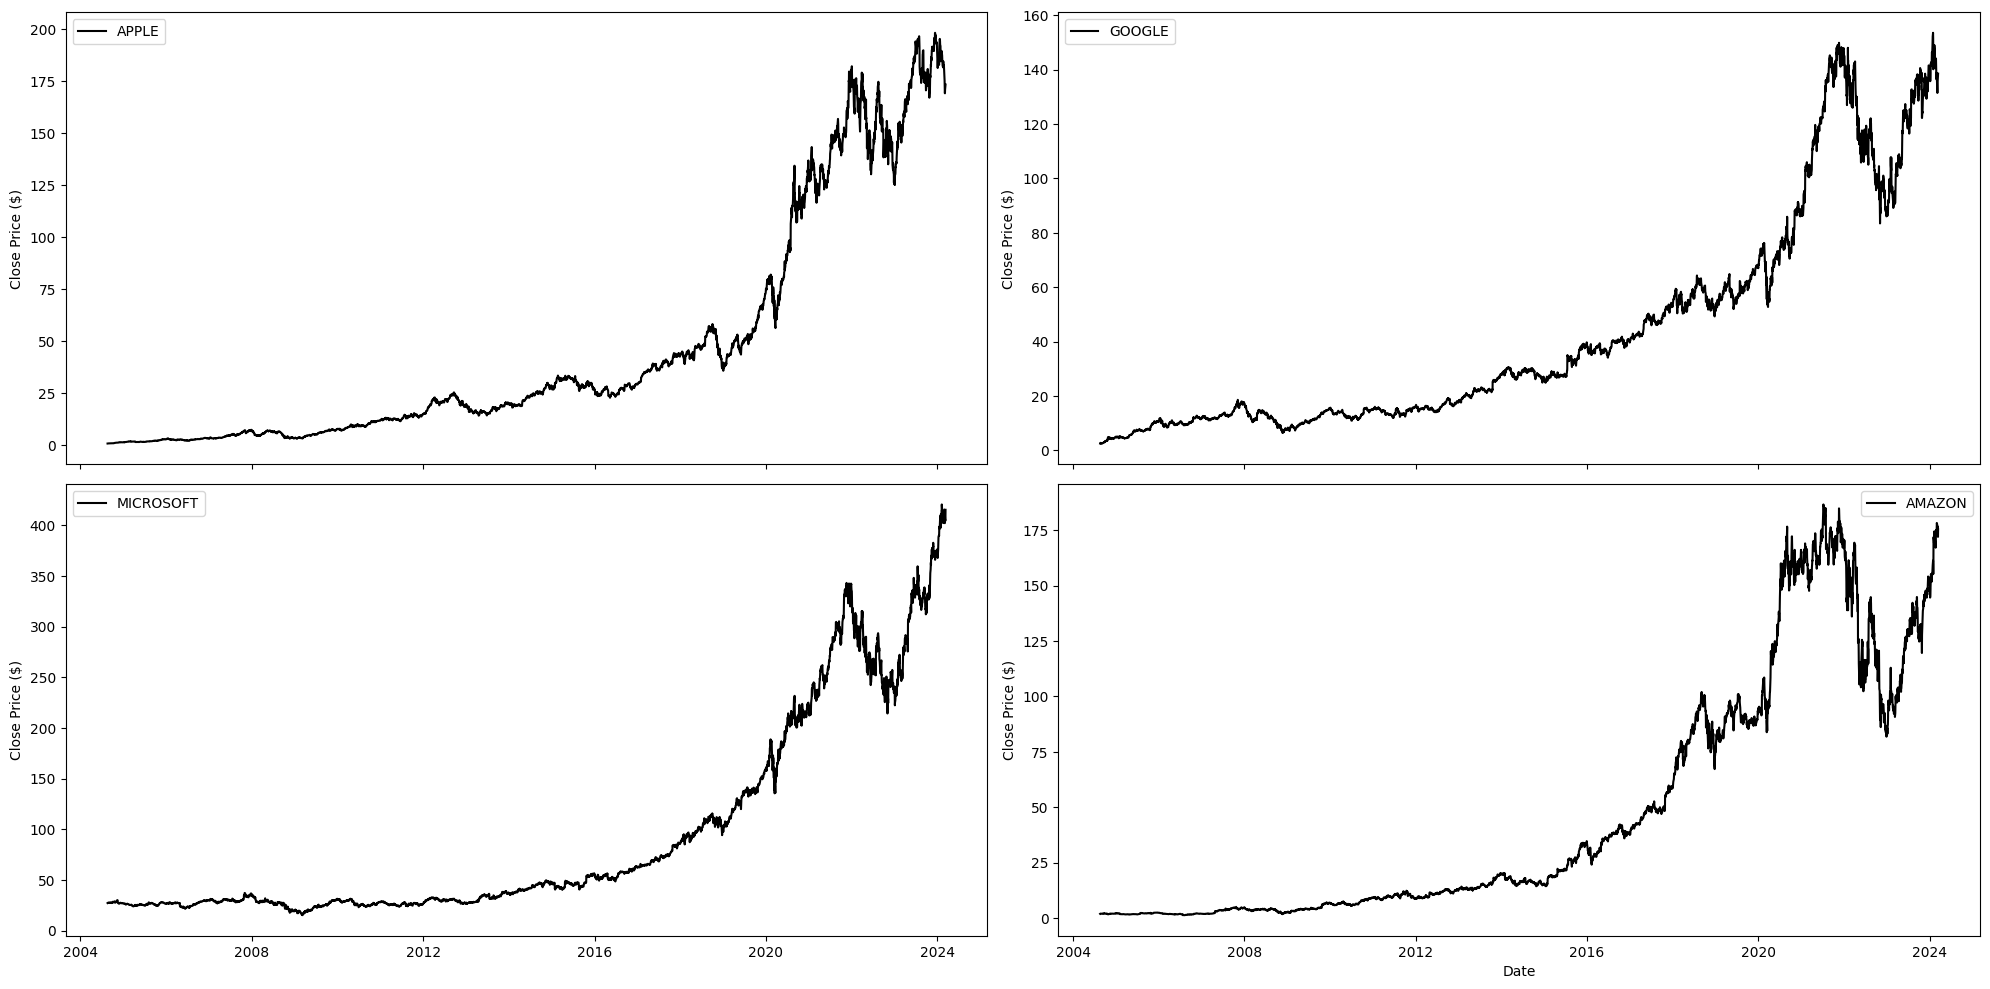

In [384]:
# Plot the time evolution for each column
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True)

for i, col_name in enumerate(close_prices_df.columns):
    row = i // 2
    col = i % 2
    axs[row, col].plot(close_prices_df.index, close_prices_df[col_name], label=col_name, color=gt_color)
    axs[row, col].set_ylabel('Close Price ($)')
    axs[row, col].legend()

# Set common labels
plt.xlabel('Date')

# Show plot
plt.tight_layout()
plt.show()



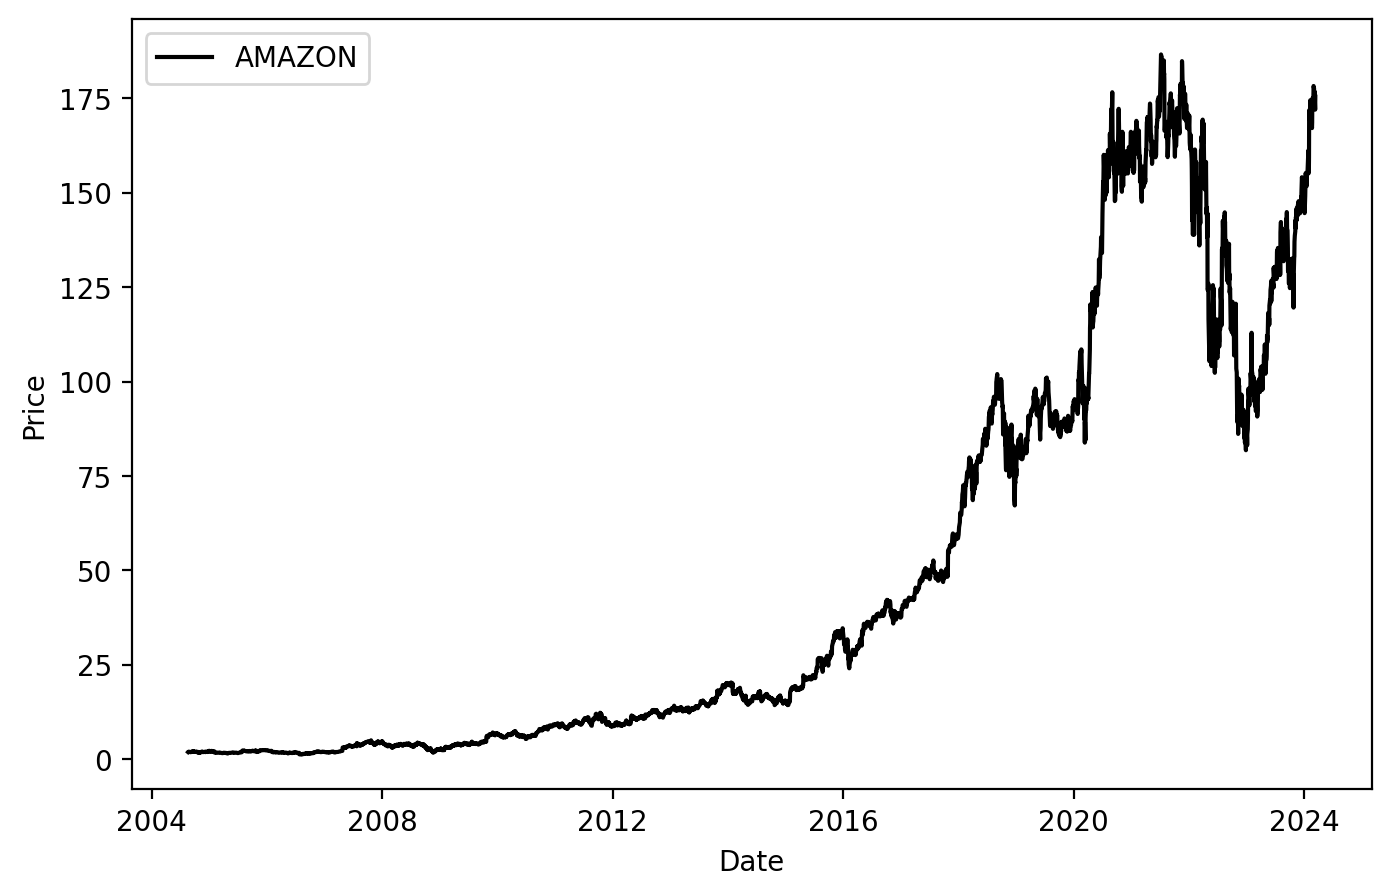

In [385]:
plot_individual_stock(df=close_prices_df, name='AMAZON', year_ticks=False)

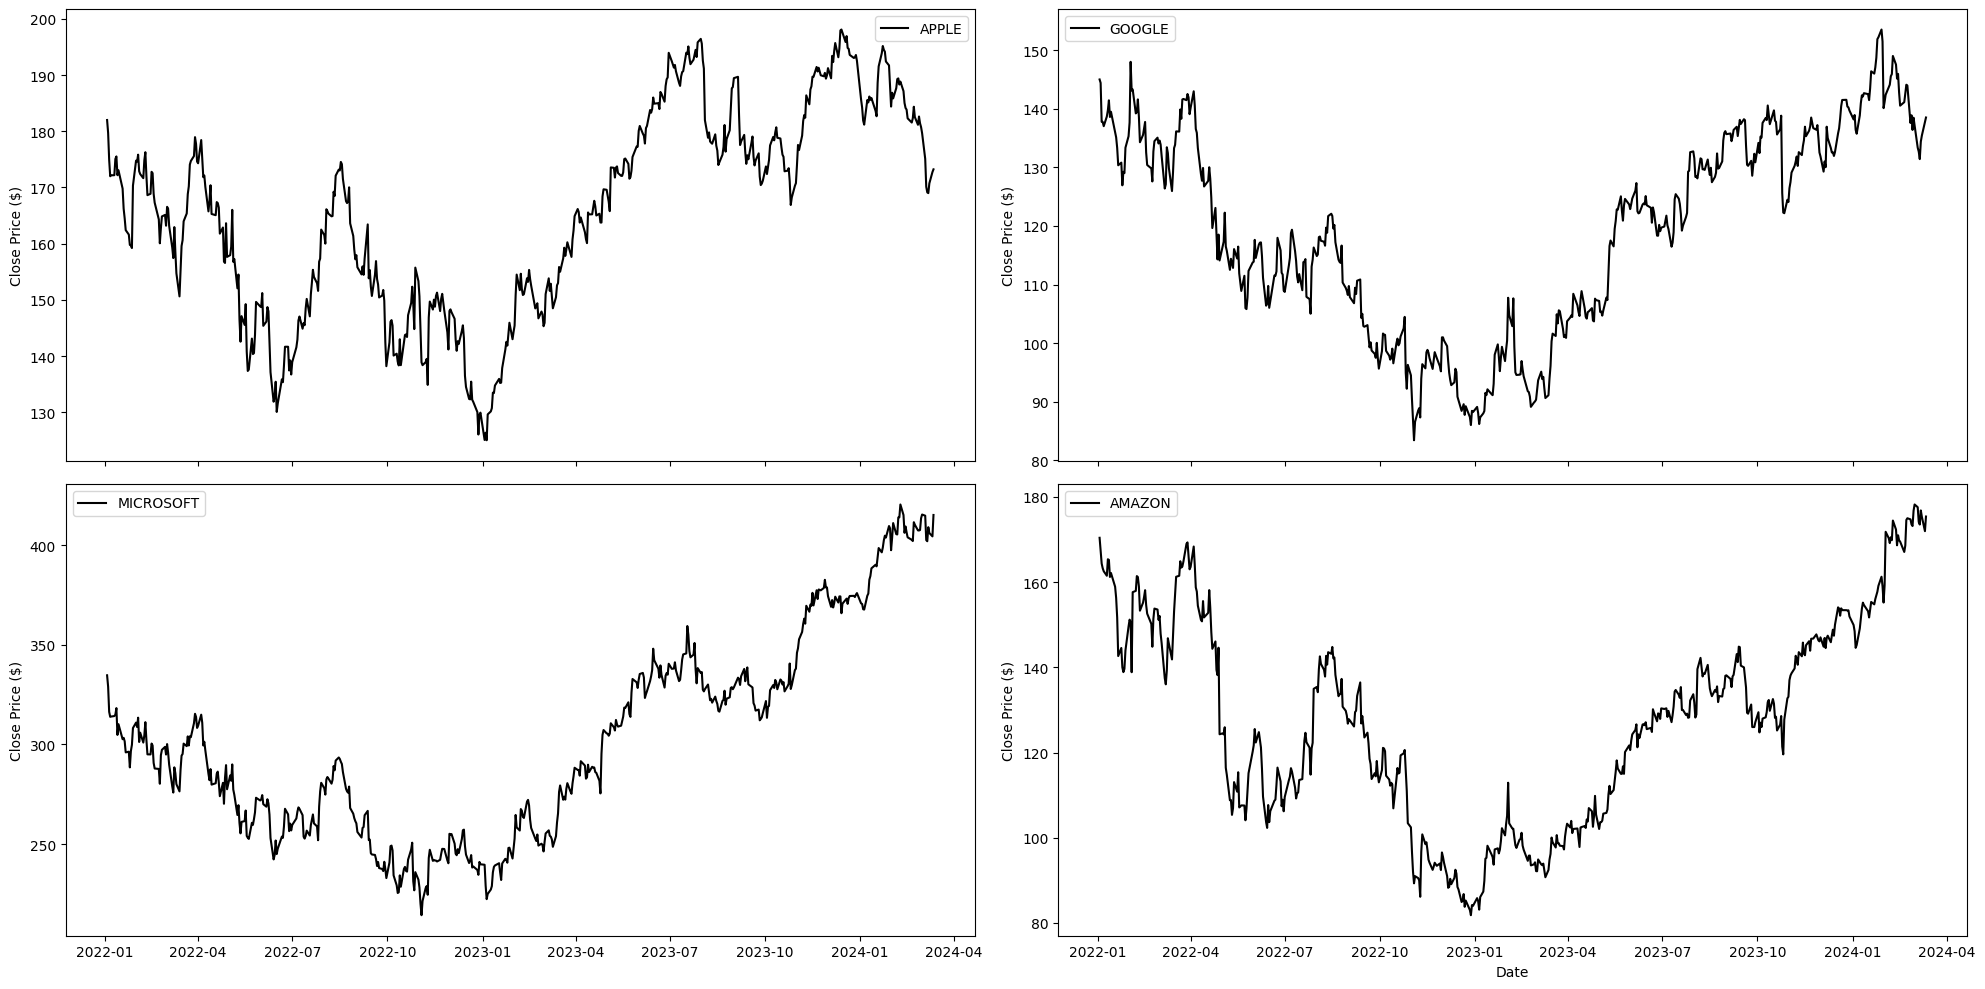

In [386]:
# Filter DataFrame to include only years after 2022
close_prices_df = close_prices_df[close_prices_df.index.year > 2021]

# Plot the time evolution for each column
fig, axs = plt.subplots(2, 2, figsize=(20, 10), sharex=True)

for i, col_name in enumerate(close_prices_df.columns):
    row = i // 2
    col = i % 2
    axs[row, col].plot(close_prices_df.index, close_prices_df[col_name], label=col_name, color=gt_color)
    axs[row, col].set_ylabel('Close Price ($)')
    axs[row, col].legend()

# Set common labels
plt.xlabel('Date')

# Show plot
plt.tight_layout()
plt.show()

In [387]:
print(close_prices_df)


             APPLE  GOOGLE  MICROSOFT  AMAZON
date                                         
2022-01-03  182.01  144.99     334.75  170.40
2022-01-04  179.70  144.40     329.01  167.52
2022-01-05  174.92  137.77     316.38  164.36
2022-01-06  172.00  137.75     313.88  163.25
2022-01-07  172.17  137.02     314.04  162.55
...            ...     ...        ...     ...
2024-03-06  169.12  131.40     402.09  173.51
2024-03-07  169.00  134.38     409.14  176.82
2024-03-08  170.73  135.41     406.22  175.35
2024-03-11  172.75  137.67     404.52  171.96
2024-03-12  173.23  138.50     415.28  175.39

[550 rows x 4 columns]


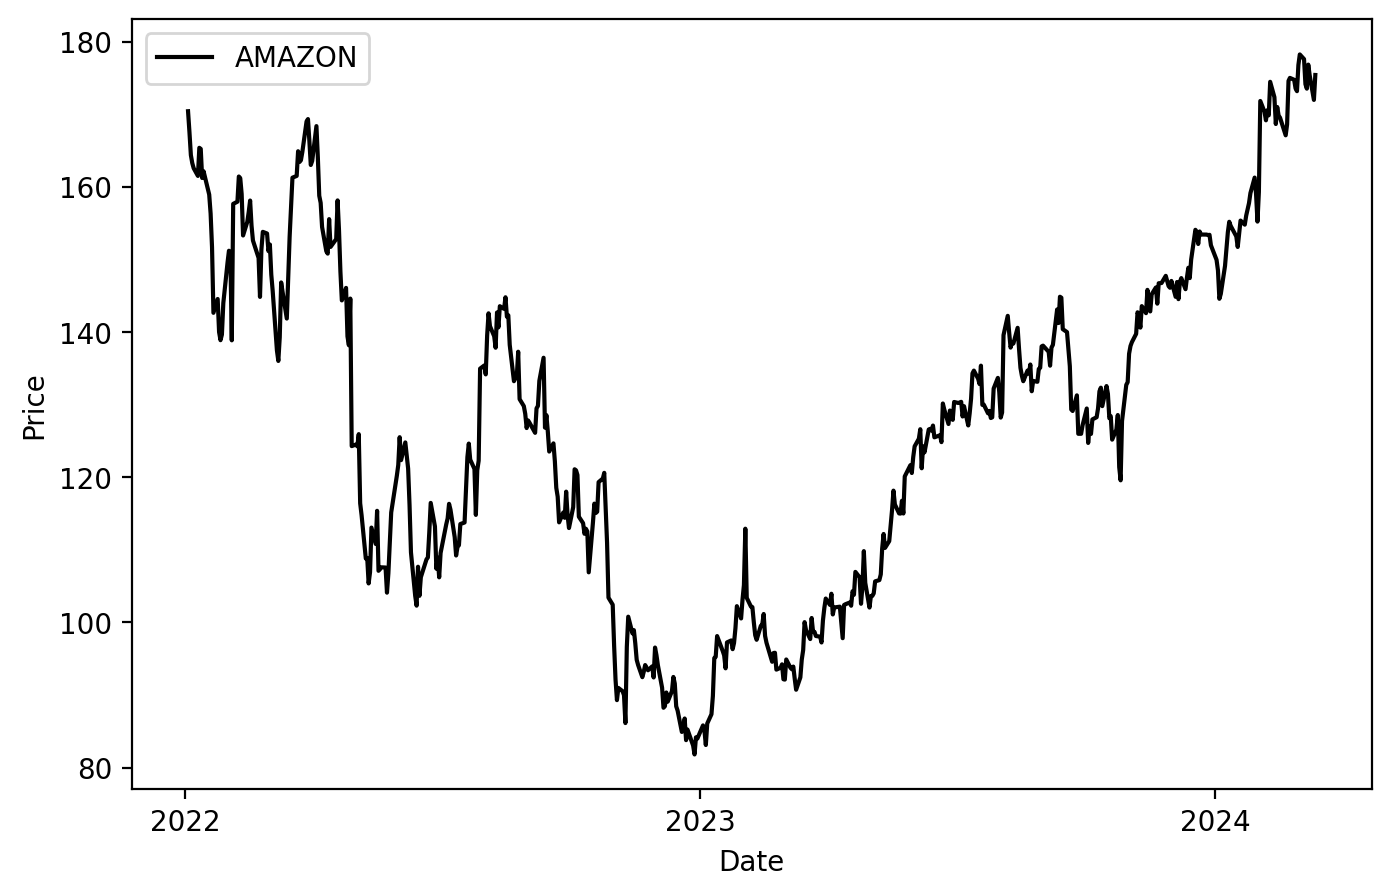

In [388]:
plot_individual_stock(df=close_prices_df, name='AMAZON', year_ticks=True)

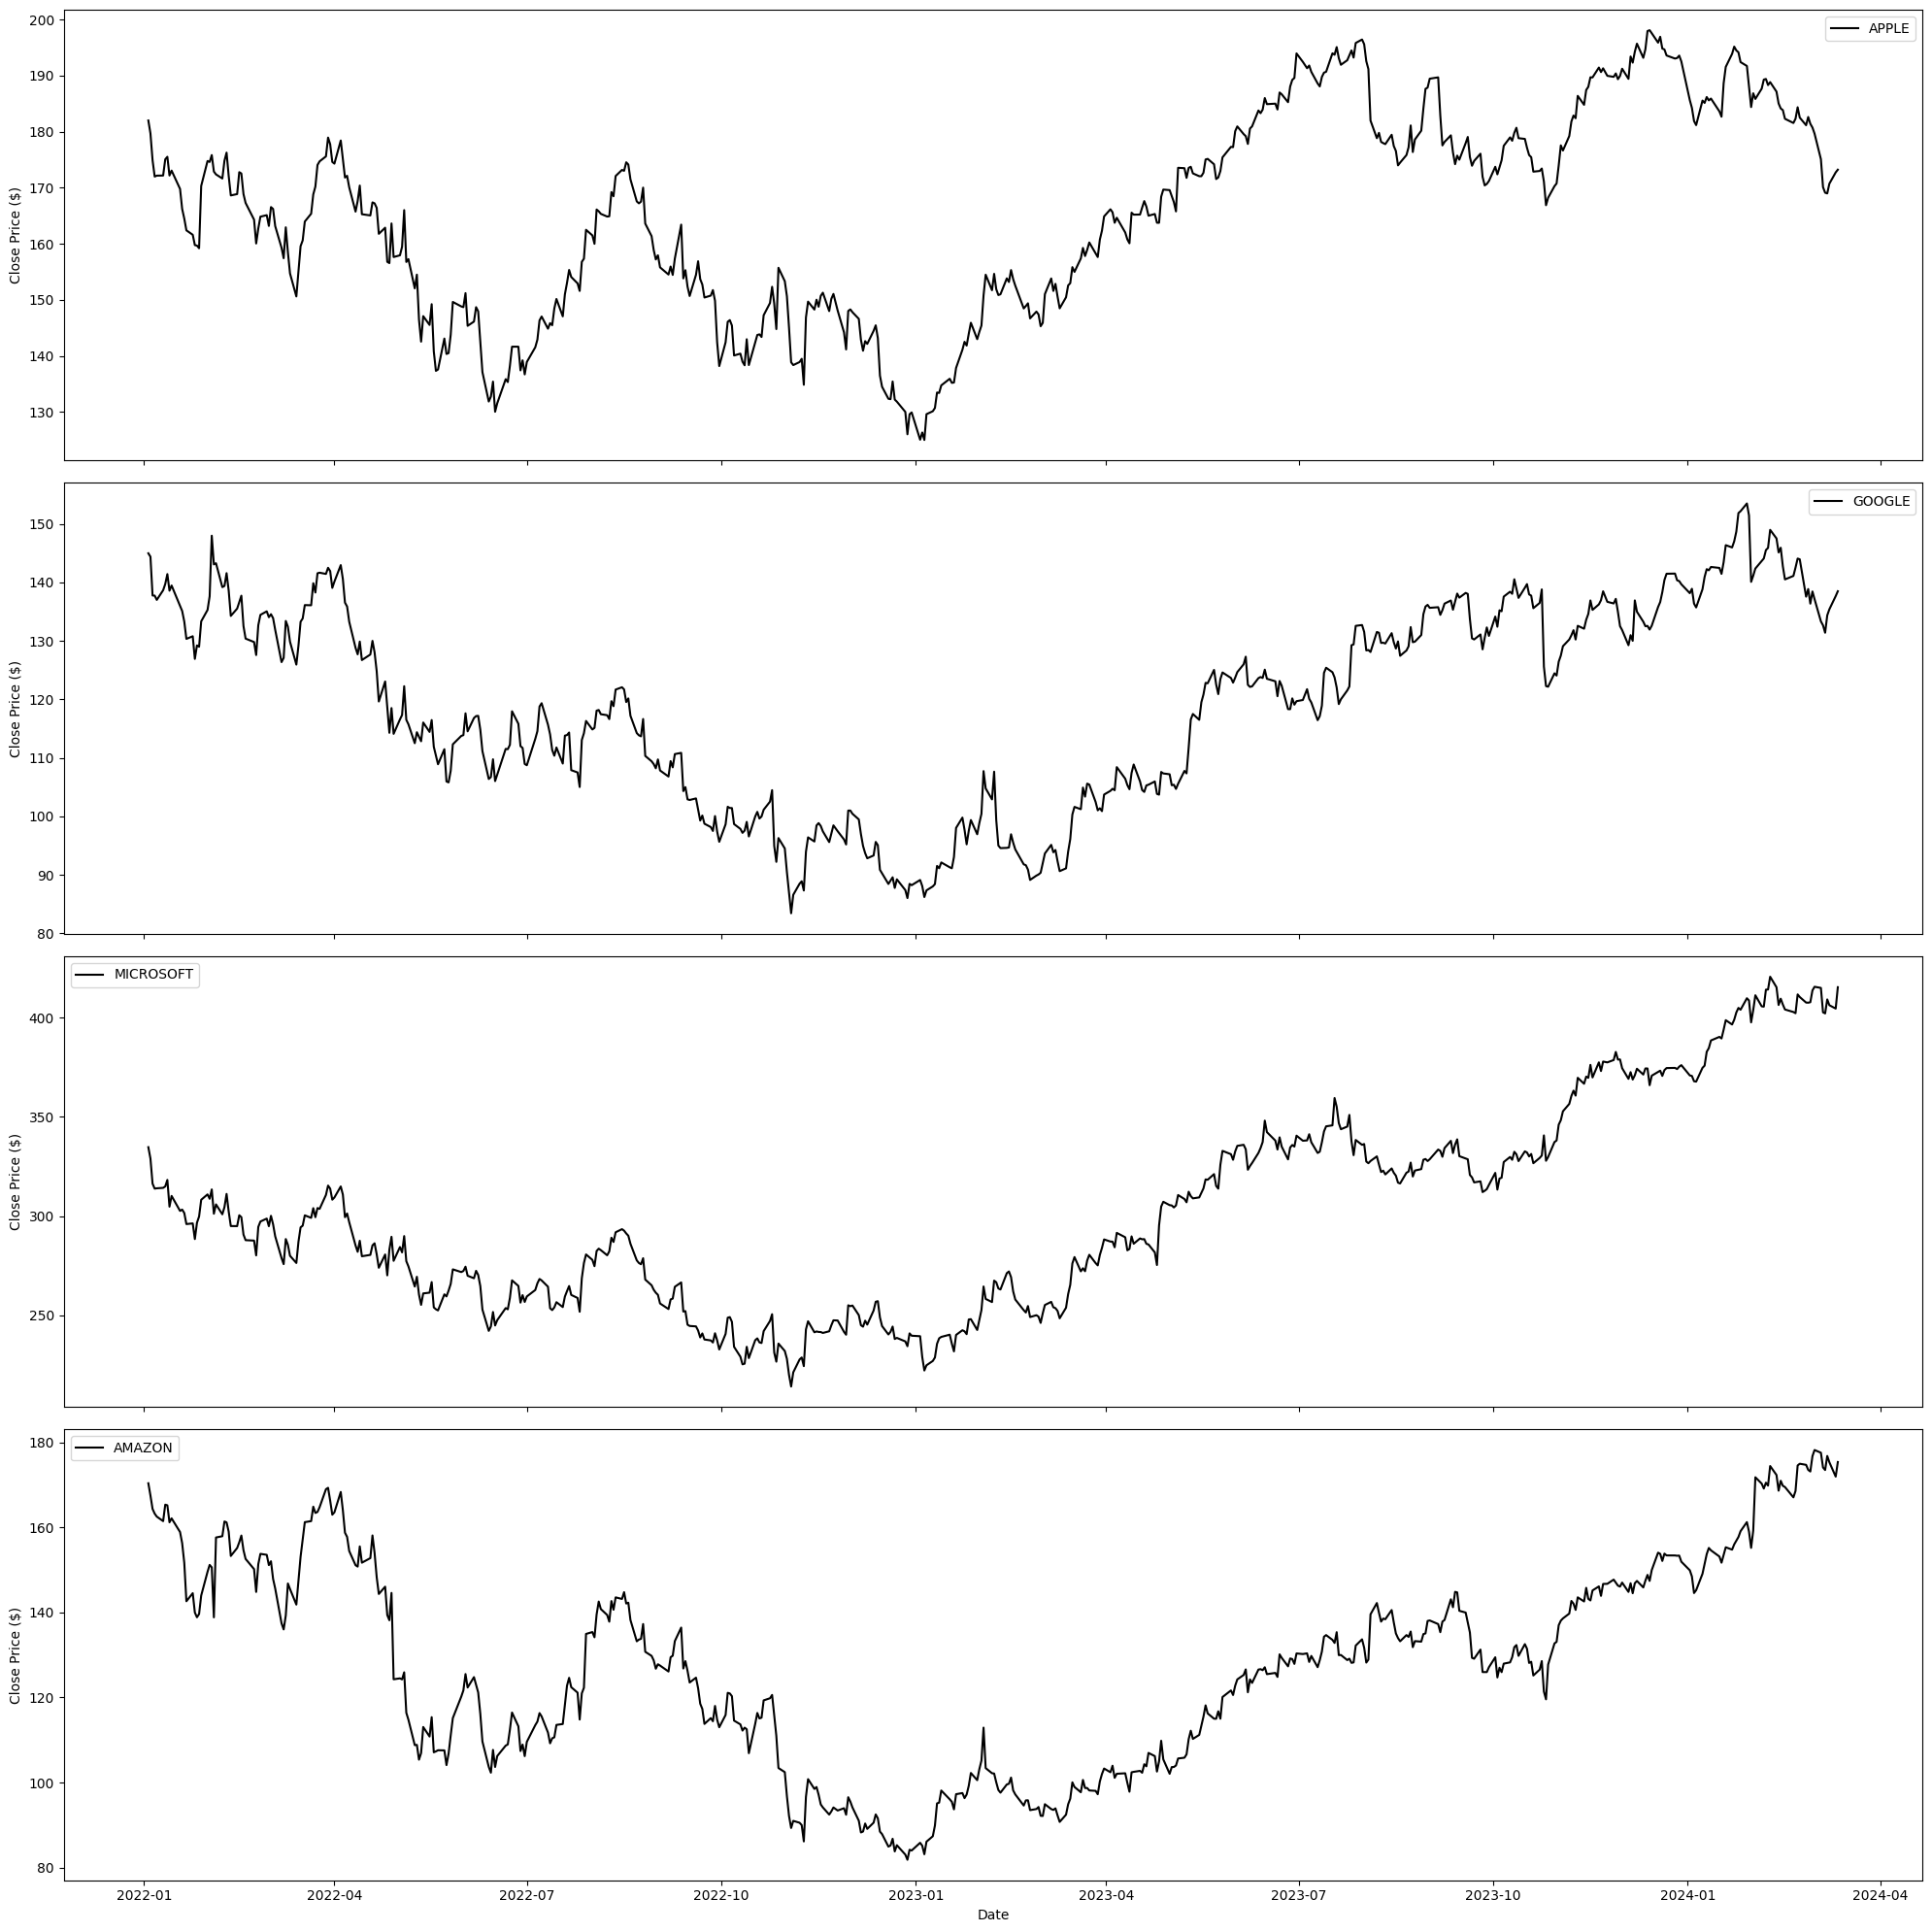

In [389]:
# Plot the time evolution for each column
fig, axs = plt.subplots(4, 1, figsize=(20, 20), sharex=True)

for i, col in enumerate(close_prices_df.columns):
    axs[i].plot(close_prices_df.index, close_prices_df[col], label=col, color=gt_color)
    axs[i].set_ylabel('Close Price ($)')
    axs[i].legend()

# Set common labels
plt.xlabel('Date')

# Show plot
plt.tight_layout()
plt.show()

GARCH

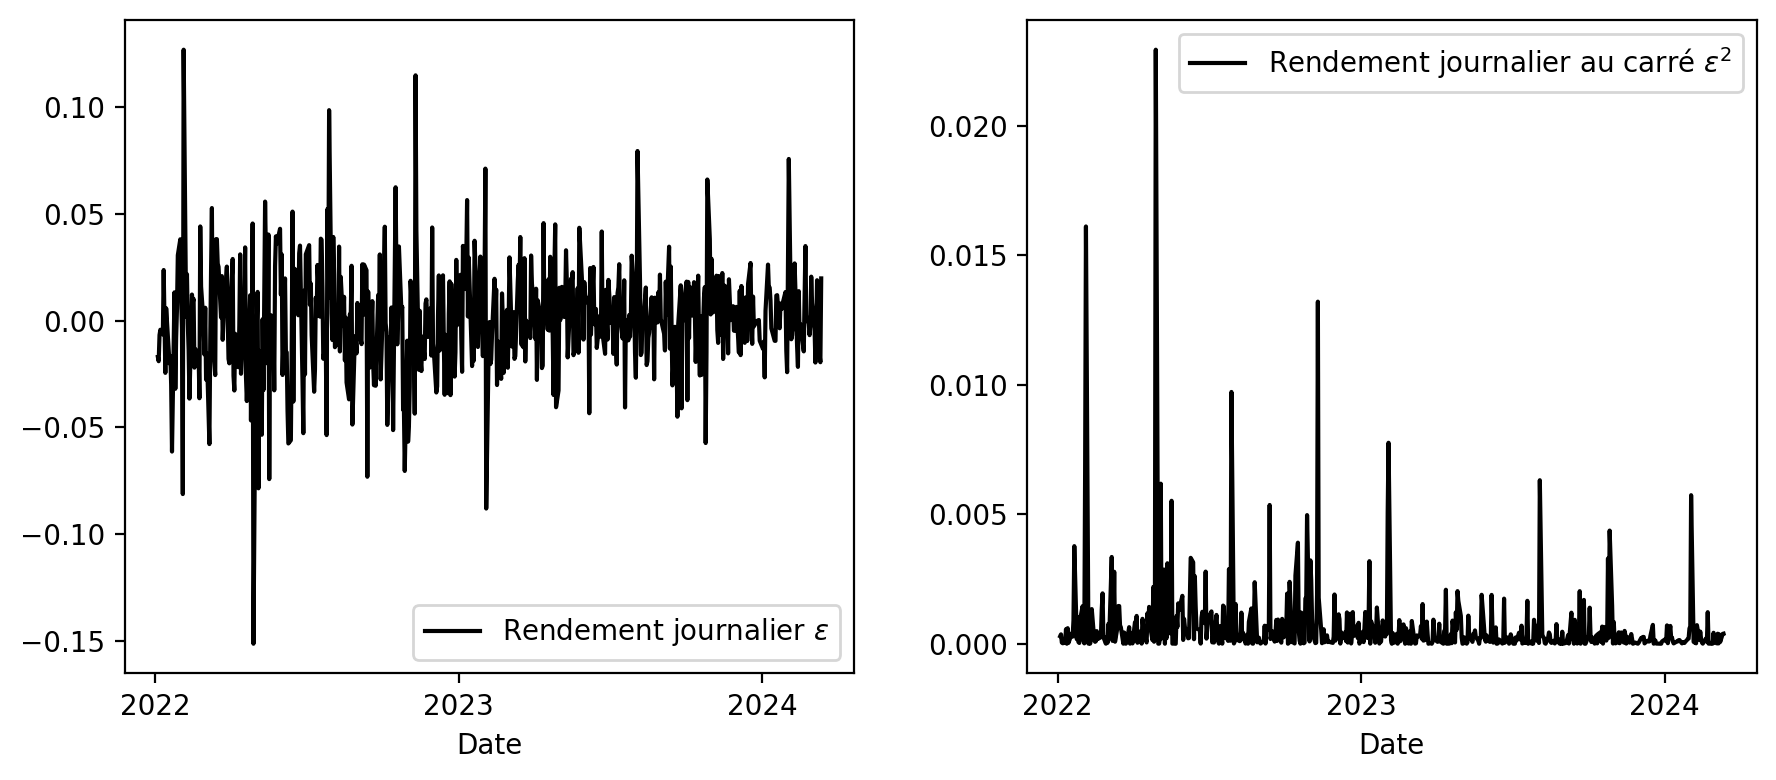

In [390]:
df_amzn = close_prices_df[['AMAZON']].copy()
df_amzn.rename(columns={'AMAZON': 'close'}, inplace=True)

# compute daily returns
df_amzn['return'] = np.log(df_amzn['close'] / df_amzn['close'].shift(1))
df_amzn['return_squared'] = df_amzn['return'] ** 2
df_amzn.dropna(inplace=True)

# Plot return and return squared in two subplots next to each other
fig, axs = plt.subplots(1, 2, figsize=(9.2,4),dpi=200)

# Plot return
axs[0].plot(df_amzn.index, df_amzn['return'], color=gt_color, label=r'Rendement journalier $\varepsilon$')
axs[0].set_xlabel('Date')
axs[0].legend()

# Plot return squared
axs[1].plot(df_amzn.index, df_amzn['return_squared'], color=gt_color, label=r'Rendement journalier au carré $\varepsilon^2$')
axs[1].set_xlabel('Date')
axs[1].legend()

# Adjust layout
plt.tight_layout()

for ax in axs:
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

Fitting GARCH

In [391]:
p,q = 3,3

model = arch.arch_model(df_amzn['return'], vol='Garch', p=p, q=q)

# Specify split date
split_date = dt.datetime(2023, 6, 1)
split_index = df_amzn.index.get_loc(split_date)
x = np.arange(split_index, len(df_amzn))

# Fit GARCH(p,q) model using data up to the split date
res = model.fit(last_obs=split_date)

Iteration:      1,   Func. Count:     10,   Neg. LLF: 32300692.710182723
Iteration:      2,   Func. Count:     25,   Neg. LLF: 3903.8451330329976
Iteration:      3,   Func. Count:     35,   Neg. LLF: 560464.8804563887
Iteration:      4,   Func. Count:     46,   Neg. LLF: -680.4155282241363
Iteration:      5,   Func. Count:     56,   Neg. LLF: -754.0270900265498
Iteration:      6,   Func. Count:     66,   Neg. LLF: -749.5104003439951
Iteration:      7,   Func. Count:     76,   Neg. LLF: -753.1803542474402
Iteration:      8,   Func. Count:     86,   Neg. LLF: -709.5992827044147
Iteration:      9,   Func. Count:     96,   Neg. LLF: -755.4088504592478
Iteration:     10,   Func. Count:    105,   Neg. LLF: -755.3987276295081
Iteration:     11,   Func. Count:    115,   Neg. LLF: -755.4300854420012
Iteration:     12,   Func. Count:    124,   Neg. LLF: -755.438253430623
Iteration:     13,   Func. Count:    133,   Neg. LLF: -755.4383035797193
Iteration:     14,   Func. Count:    142,   Neg. LLF:

/Users/tessbreton/Documents/polytechnique/3A/MAP565 Modélisation aléatoire et Statistiques des processus/.venv/lib/python3.12/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008676. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [392]:
# Make forecasts
forecasts = res.forecast(horizon=len(df_amzn.index[x]), start=split_date, method="simulation")
sims = forecasts.simulations

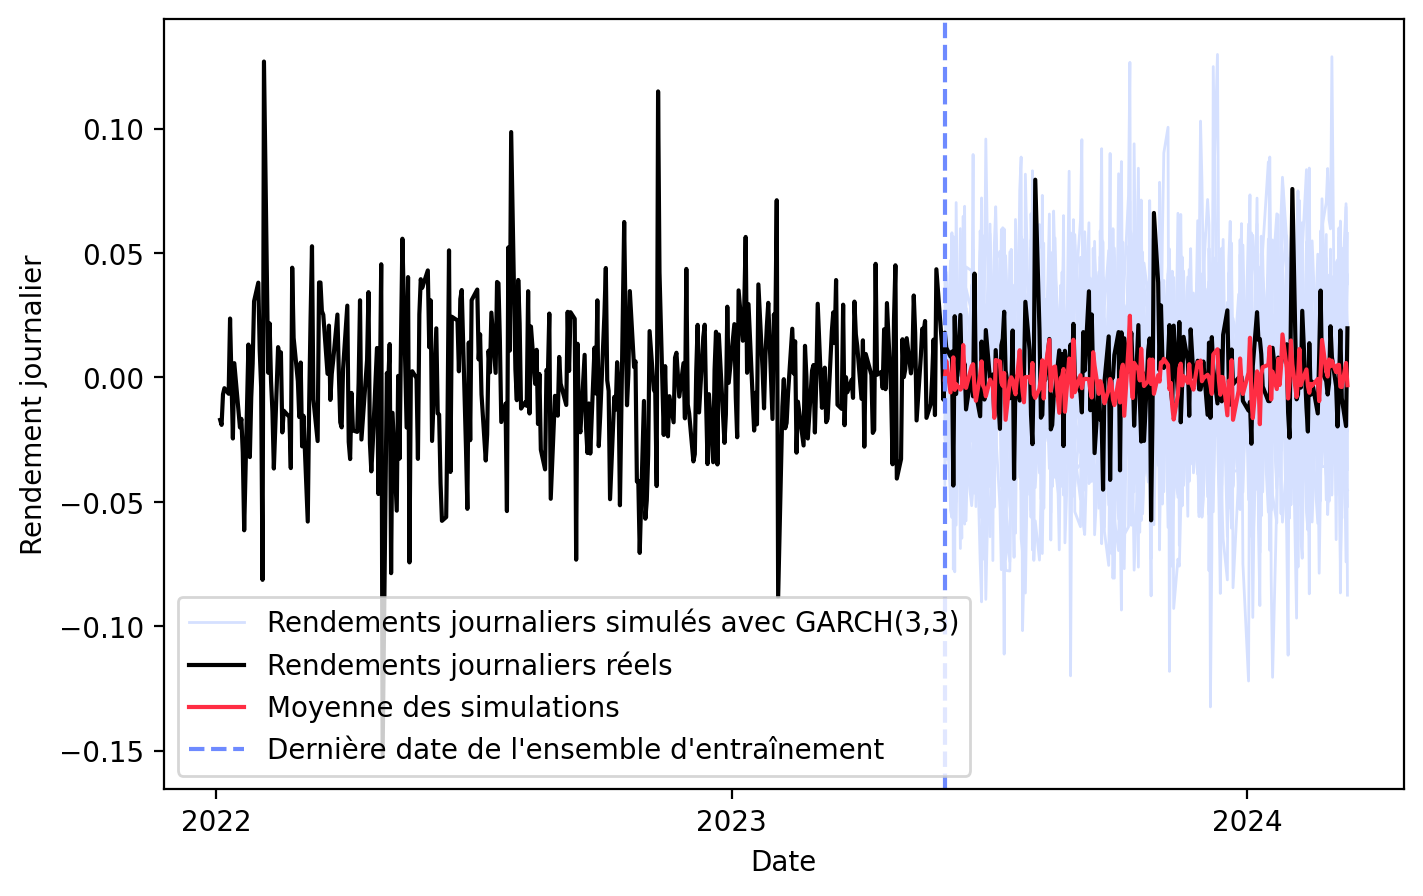

In [393]:
plt.figure(figsize=(8,5), dpi=200)

nb_sim = 20

mean_simulations = np.mean(sims.values[-1, :nb_sim], axis=0)

# Plot simulations 
plt.plot(df_amzn.index[x], sims.values[-1, :nb_sim].T, color=simulations_color, linewidth=1, label=f'Rendements journaliers simulés avec GARCH({p},{q})')

# Plotting ground truth data
plt.plot(df_amzn.index, df_amzn['return'], label='Rendements journaliers réels', color=gt_color)

# Plot mean over all simulations for each timestamp
plt.plot(df_amzn.index[x], mean_simulations, color=mean_color, label="Moyenne des simulations")

# Plot vertical line to split train/test
plt.axvline(x=split_date, linestyle='--', color=dashed_line_color, label="Dernière date de l'ensemble d'entraînement")

plt.ylabel('Rendement journalier')
plt.xlabel('Date')
year_ticks()
legend_unique_labels()

plt.show()


In [394]:
mean_simulations

array([-8.64647740e-04,  6.65447480e-03, -6.00654969e-03,  1.12140054e-03,
        8.07587640e-03, -4.97412001e-03, -2.68871838e-03, -4.88024098e-03,
       -4.10754556e-03,  1.30135882e-02, -8.01480466e-05, -4.17578224e-03,
        4.55854284e-03,  5.32668008e-03, -4.96192146e-03, -9.33637879e-03,
        9.77488999e-04,  6.46697323e-03, -3.12590117e-03, -4.38203032e-03,
       -7.53907822e-03, -8.31815754e-04, -3.32805051e-03, -1.62149606e-02,
        7.02739498e-03,  6.42518380e-03, -2.06137257e-03, -3.39442663e-03,
        1.79924132e-03, -1.70032540e-02, -1.33306024e-03,  6.49654950e-05,
       -1.01490538e-03, -4.41165550e-03, -6.72329166e-03,  1.09492001e-02,
        1.10608276e-03, -5.51632860e-03, -9.96359686e-03,  1.13704108e-04,
        2.25934427e-04, -2.25729762e-03,  5.81014069e-03, -6.89236792e-03,
       -8.18407059e-03, -4.52201549e-03,  1.50088283e-04,  6.89812785e-03,
       -8.43784611e-03,  2.90598232e-03,  1.51472939e-02, -5.27813513e-03,
        1.09725249e-03,  

Obtenir les prédictions du cours de l'action à partir des rendements:

In [395]:
# Get the last observed closing price before the split date
prev_close = df_amzn['close'].iloc[split_index - 1]
predicted_prices = get_predicted_prices(sims, nb_sim, prev_close)

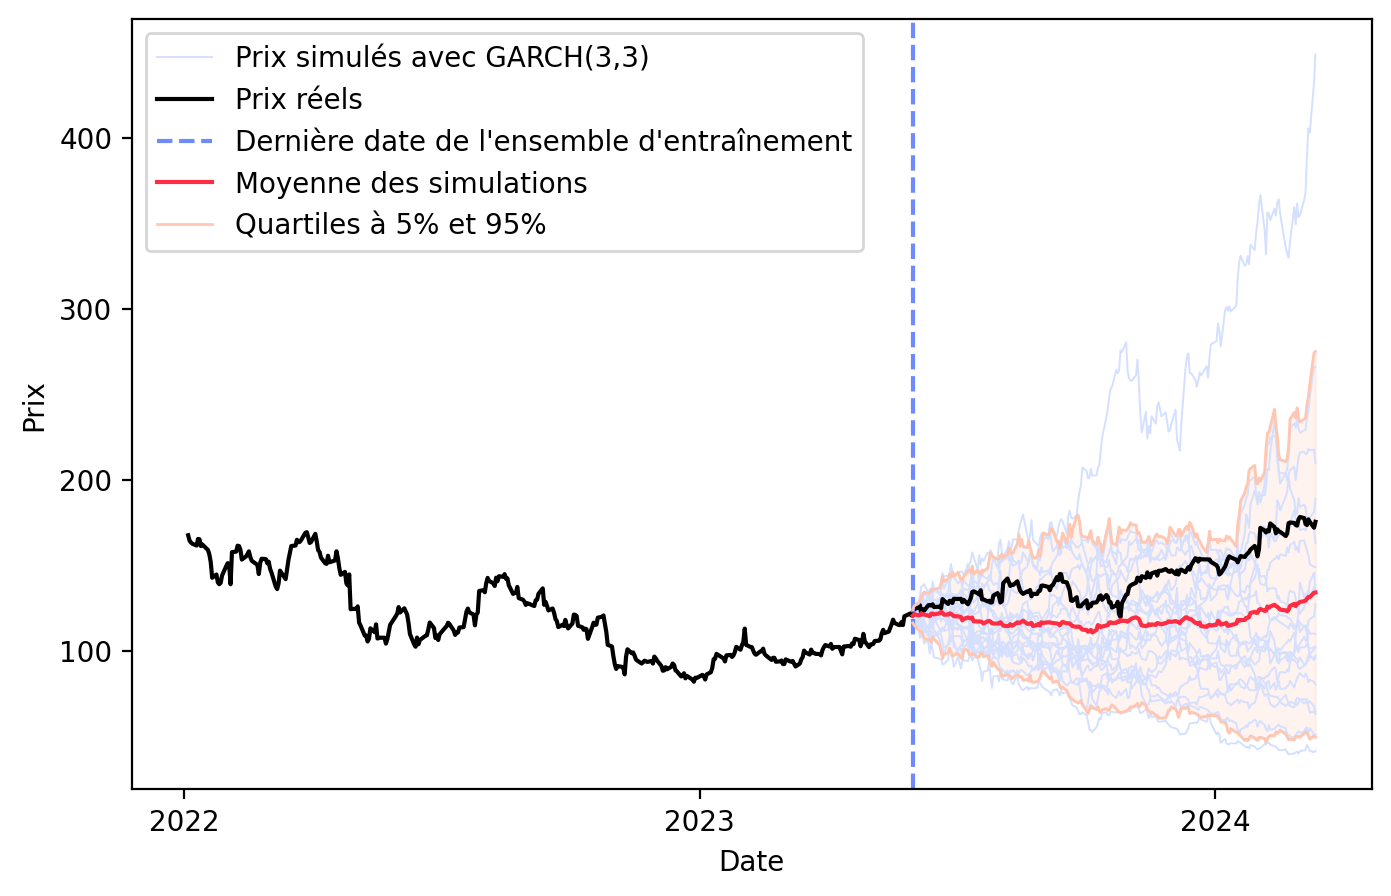

In [396]:
plt.figure(figsize=(8, 5), dpi=200)

x_pred = df_amzn.index[x]
plt.plot(x_pred, predicted_prices[1:], color=simulations_color, linewidth=0.7, label=f"Prix simulés avec GARCH({p},{q})")
plt.plot(df_amzn.index, df_amzn['close'], label='Prix réels', color=gt_color)
plt.axvline(x=split_date, linestyle='--', color=dashed_line_color, label="Dernière date de l'ensemble d'entraînement")
plt.plot(x_pred, np.mean(predicted_prices[1:],axis=1), label='Moyenne des simulations', color=mean_color)

# Plot quartile lines
quartile_5, quartile_95 = get_quartiles(predicted_prices)
plt.plot(x_pred, quartile_5, color=quartile_color, lw=1, label='Quartiles à 5% et 95%')
plt.plot(x_pred, quartile_95, color=quartile_color, lw=1)
plt.fill_between(x_pred, quartile_5, quartile_95, color=quartile_color, alpha=0.2)

plt.ylabel("Prix")
plt.xlabel('Date')
year_ticks()
legend_unique_labels()

plt.show()


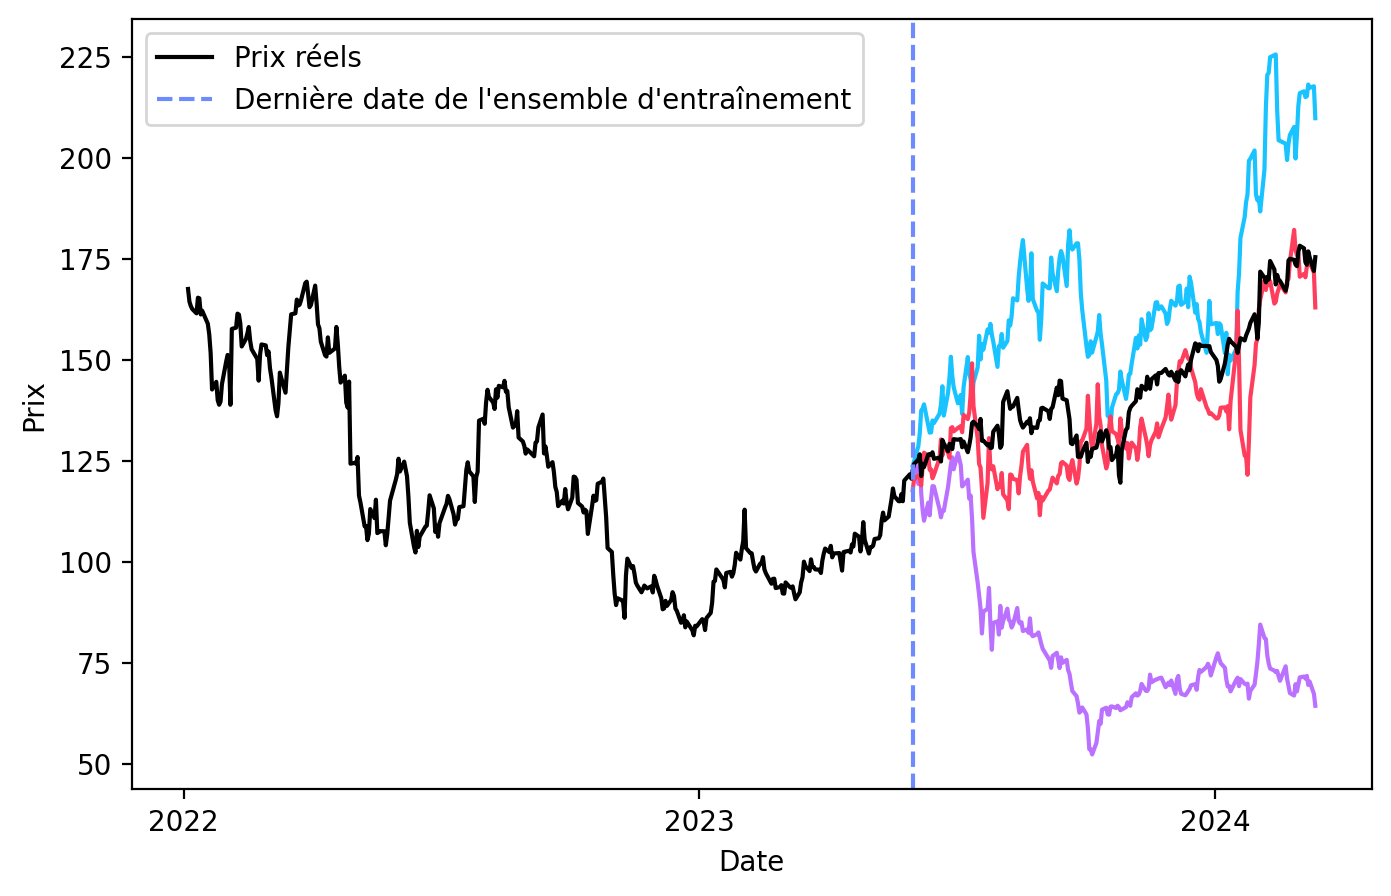

In [401]:
plt.figure(figsize=(8, 5), dpi=200)

x_pred = df_amzn.index[x]
# Array de couleurs
colors = ['#BB71FF', '#18C3FF', '#FF3E5D', '#FFB84C', '#A459D1']

# Itérer sur les 5 premiers éléments de l'axe 1 et les tracer
for i in range(3):
    plt.plot(x_pred,np.array(predicted_prices[1:])[:, i+5], color=colors[i])
plt.plot(df_amzn.index, df_amzn['close'], label='Prix réels', color=gt_color)
plt.axvline(x=split_date, linestyle='--', color=dashed_line_color, label="Dernière date de l'ensemble d'entraînement")

plt.ylabel("Prix")
plt.xlabel('Date')
year_ticks()
legend_unique_labels()

plt.show()

Prédire le cours de l'action pour les années à venir:

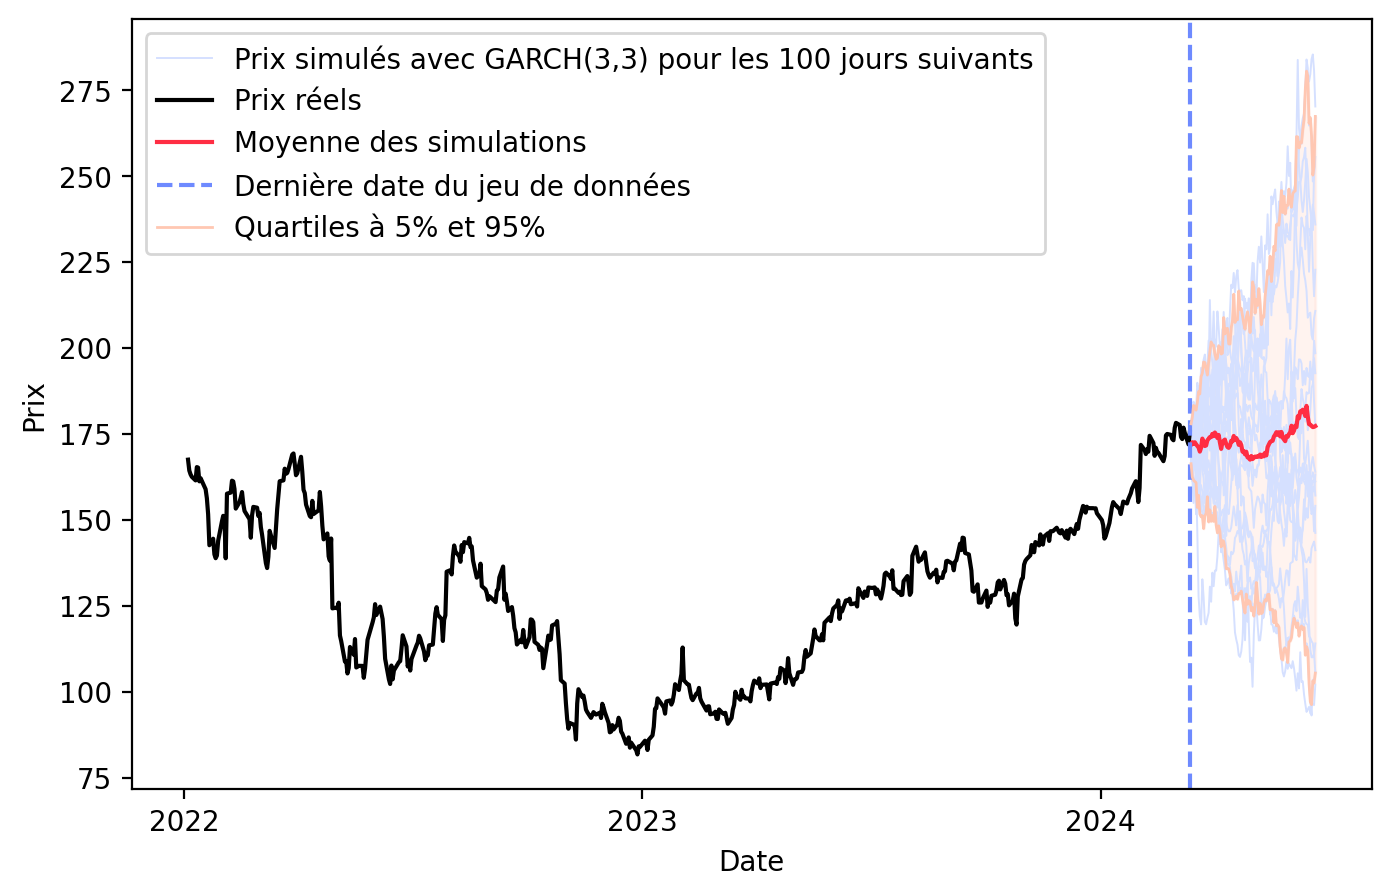

In [378]:
# Find the index of the split date in df_amzn
split_index = len(df_amzn) - 1
split_date = df_amzn.index[split_index]
prev_close = df_amzn['close'].iloc[split_index - 1]

# Set the horizon for the forecasts (100 days)
horizon = 100

# Make forecasts for the next 100 days after the split date
forecasts = res.forecast(horizon=horizon, start=split_date, method='simulation')
sims = forecasts.simulations
predicted_prices = get_predicted_prices(sims, nb_sim, prev_close)

# Generate x-axis index for the next 100 days after the split date
x_pred = pd.date_range(start=df_amzn.index[split_index], periods=horizon + 1)[1:]

# Plot the predictions for the next 100 days after the split date
plt.figure(figsize=(8, 5),dpi=200)

plt.plot(x_pred, predicted_prices[1:], color=simulations_color, linewidth=0.7, label=f"Prix simulés avec GARCH({p},{q}) pour les {horizon} jours suivants")
plt.plot(df_amzn.index, df_amzn['close'], label='Prix réels', color=gt_color)
plt.plot(x_pred, np.mean(predicted_prices[1:],axis=1), label='Moyenne des simulations', color=mean_color)
plt.axvline(x=split_date, linestyle='--', color=dashed_line_color, label='Dernière date du jeu de données')

# Plot quartile lines
quartile_5, quartile_95 = get_quartiles(predicted_prices)
plt.plot(x_pred, quartile_5, color=quartile_color, lw=1, label='Quartiles à 5% et 95%')
plt.plot(x_pred, quartile_95, color=quartile_color, lw=1)
plt.fill_between(x_pred, quartile_5, quartile_95, color=quartile_color, alpha=0.2)

plt.ylabel("Prix")
plt.xlabel('Date')
year_ticks()
legend_unique_labels()

plt.show()
